In [1]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.0.0+cpu


'cpu'

In [2]:
import torchvision

train_dataset = torchvision.datasets.MNIST(root='.',
                                          train=True,
                                          download=True,
                                          transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='.',
                                          train=False,
                                          download=True,
                                          transform=torchvision.transforms.ToTensor())
train_dataset, test_dataset

50.9%

100.0%


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



100.0%

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw




100.0%

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw




100.0%

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [3]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [4]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

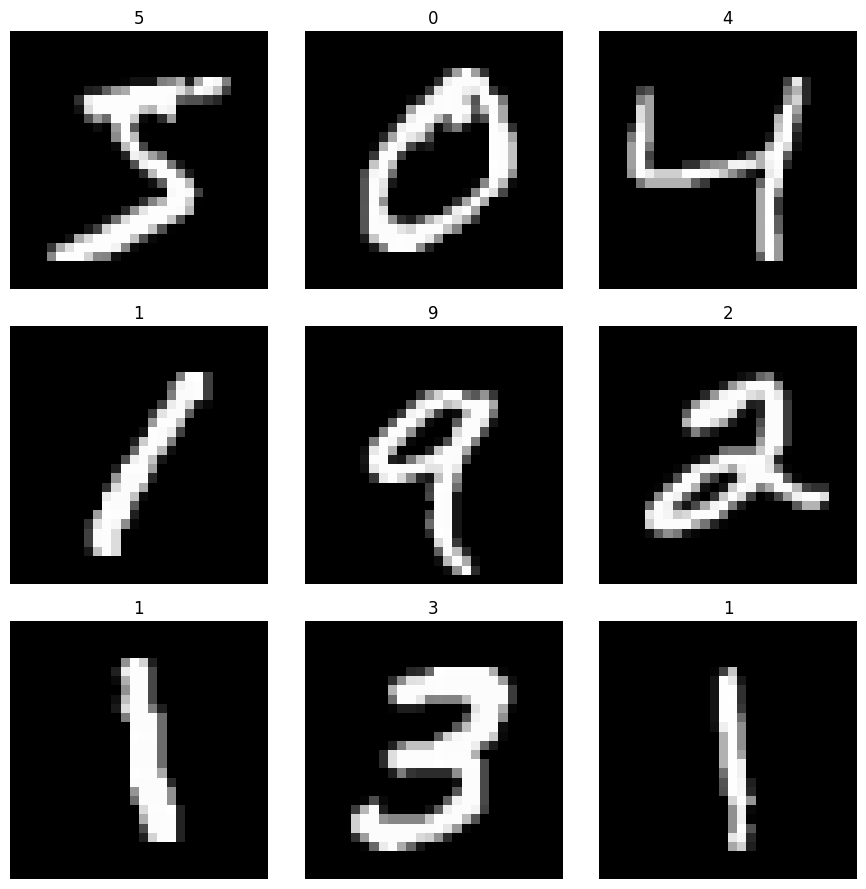

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i in range (0,9):
    ax = axes[i // 3, i % 3]
    ax.imshow(train_dataset[i][0].squeeze(), cmap='gray')
    ax.set_title(train_dataset[i][1])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=True
)

In [7]:
from torch import nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = 1,
                      out_channels = 6,
                      kernel_size = 5,
                      stride = 1,
                      padding = 2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = 2,
                       stride = 2,
                       padding = 0)

        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = 6,
                      out_channels = 16,
                      kernel_size = 5,
                      stride = 1,
                      padding = 0),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size = 2,
                       stride = 2,
                       padding = 0)
        )
        self.flatten = nn.Flatten()
        self.layer_1 = nn.Linear(in_features = 16*5*5,
                                 out_features = 120)
        self.layer_2 = nn.Linear(in_features = 120,
                                 out_features = 84)
        self.layer_3 = nn.Linear(in_features = 84,
                                 out_features = 10)

    def forward(self, x):
        x = self.cnn_block_1(x)
        #print(x.shape)
        x = self.cnn_block_2(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = F.sigmoid(self.layer_1(x))
        #print(x.shape)
        x = F.sigmoid(self.layer_2(x))
        #print(x.shape)
        x = self.layer_3(x)
        return x

In [8]:
model = LeNet().to(device)
model

LeNet(
  (cnn_block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=400, out_features=120, bias=True)
  (layer_2): Linear(in_features=120, out_features=84, bias=True)
  (layer_3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
dummy_data = torch.randn(1, 1, 28, 28).to('cpu')

model(dummy_data)

tensor([[ 0.2082, -0.1813,  0.0801, -0.1916,  0.1454,  0.0832, -0.0728, -0.1348,
          0.1239,  0.4552]], grad_fn=<AddmmBackward0>)

In [10]:
try:
    import torchmetrics, mlxtend
except:
    !pip install torchmetrics
    !pip install mlxtend

c:\Users\Michal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [20]:
from tqdm.auto import tqdm
import torchmetrics

model_cpu = LeNet().to('cpu')

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_cpu.parameters(), lr=0.1)
accuracy_fn = torchmetrics.Accuracy(task='multiclass',
                                    num_classes=len(class_names))

epochs = 30
for epoch in tqdm(range(epochs)):
    model_cpu.train()
    train_loss = 0.0
    train_acc = 0.0
    for X, y in train_dataloader:
        X, y = X.to('cpu'), y.to('cpu')

        optimizer.zero_grad()
        y_pred = model_cpu(X)
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y_pred.softmax(dim=1), y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    accuracy_fn.reset()

    model_cpu.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to('cpu'), y.to('cpu')
            y_pred = model_cpu(X)
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred.softmax(dim=1), y)

            test_loss += loss.item()
            test_acc += acc.item()

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    accuracy_fn.reset()

    print(f"Epoch {epoch+1}/{epochs} => "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
          f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")


  3%|▎         | 1/30 [00:39<19:08, 39.62s/it]

Epoch 1/30 => Train loss: 2.5054, Train acc: 0.0998, Test loss: 2.4171, Test acc: 0.1027


  7%|▋         | 2/30 [01:03<14:10, 30.37s/it]

Epoch 2/30 => Train loss: 2.4864, Train acc: 0.1011, Test loss: 2.3998, Test acc: 0.1032


 10%|█         | 3/30 [01:25<12:00, 26.69s/it]

Epoch 3/30 => Train loss: 2.4923, Train acc: 0.0994, Test loss: 2.4131, Test acc: 0.1134


 13%|█▎        | 4/30 [01:49<10:59, 25.37s/it]

Epoch 4/30 => Train loss: 2.4916, Train acc: 0.1005, Test loss: 2.5532, Test acc: 0.1009


 17%|█▋        | 5/30 [02:13<10:24, 24.98s/it]

Epoch 5/30 => Train loss: 2.4928, Train acc: 0.1022, Test loss: 2.3672, Test acc: 0.1011


 20%|██        | 6/30 [02:38<09:59, 24.97s/it]

Epoch 6/30 => Train loss: 2.4912, Train acc: 0.1008, Test loss: 2.4846, Test acc: 0.0974


 23%|██▎       | 7/30 [03:02<09:28, 24.71s/it]

Epoch 7/30 => Train loss: 2.4968, Train acc: 0.0993, Test loss: 2.5919, Test acc: 0.1009


 27%|██▋       | 8/30 [03:27<09:01, 24.62s/it]

Epoch 8/30 => Train loss: 2.4975, Train acc: 0.1001, Test loss: 2.4591, Test acc: 0.1010


 30%|███       | 9/30 [03:51<08:35, 24.54s/it]

Epoch 9/30 => Train loss: 2.4935, Train acc: 0.1004, Test loss: 2.5750, Test acc: 0.0974


 33%|███▎      | 10/30 [04:16<08:11, 24.57s/it]

Epoch 10/30 => Train loss: 2.4966, Train acc: 0.1019, Test loss: 2.4894, Test acc: 0.1035


 37%|███▋      | 11/30 [04:40<07:47, 24.59s/it]

Epoch 11/30 => Train loss: 2.4986, Train acc: 0.1028, Test loss: 2.3836, Test acc: 0.0959


 40%|████      | 12/30 [05:05<07:25, 24.76s/it]

Epoch 12/30 => Train loss: 2.4936, Train acc: 0.0989, Test loss: 2.4920, Test acc: 0.1134


 43%|████▎     | 13/30 [05:33<07:18, 25.80s/it]

Epoch 13/30 => Train loss: 2.4942, Train acc: 0.1002, Test loss: 2.4307, Test acc: 0.1028


 47%|████▋     | 14/30 [05:59<06:51, 25.75s/it]

Epoch 14/30 => Train loss: 2.4891, Train acc: 0.1020, Test loss: 2.5563, Test acc: 0.1027


 50%|█████     | 15/30 [06:24<06:21, 25.45s/it]

Epoch 15/30 => Train loss: 2.4987, Train acc: 0.1010, Test loss: 2.3619, Test acc: 0.1027


 53%|█████▎    | 16/30 [06:51<06:04, 26.06s/it]

Epoch 16/30 => Train loss: 2.4967, Train acc: 0.1015, Test loss: 2.5034, Test acc: 0.1010


 57%|█████▋    | 17/30 [07:17<05:38, 26.01s/it]

Epoch 17/30 => Train loss: 2.4869, Train acc: 0.1027, Test loss: 2.4787, Test acc: 0.1028


 60%|██████    | 18/30 [07:43<05:10, 25.89s/it]

Epoch 18/30 => Train loss: 2.4774, Train acc: 0.1000, Test loss: 2.4938, Test acc: 0.0957


 63%|██████▎   | 19/30 [08:08<04:42, 25.73s/it]

Epoch 19/30 => Train loss: 2.4913, Train acc: 0.1028, Test loss: 2.4823, Test acc: 0.1011


 67%|██████▋   | 20/30 [08:34<04:16, 25.64s/it]

Epoch 20/30 => Train loss: 2.4927, Train acc: 0.0964, Test loss: 2.4329, Test acc: 0.1029


 70%|███████   | 21/30 [08:59<03:50, 25.65s/it]

Epoch 21/30 => Train loss: 2.4854, Train acc: 0.1013, Test loss: 2.5615, Test acc: 0.0957


 73%|███████▎  | 22/30 [09:25<03:26, 25.75s/it]

Epoch 22/30 => Train loss: 2.4944, Train acc: 0.1018, Test loss: 2.4262, Test acc: 0.1134


 77%|███████▋  | 23/30 [09:52<03:01, 25.92s/it]

Epoch 23/30 => Train loss: 2.4818, Train acc: 0.1009, Test loss: 2.3741, Test acc: 0.0983


 80%|████████  | 24/30 [10:20<02:40, 26.74s/it]

Epoch 24/30 => Train loss: 2.4981, Train acc: 0.1018, Test loss: 2.5588, Test acc: 0.1007


 83%|████████▎ | 25/30 [10:48<02:15, 27.13s/it]

Epoch 25/30 => Train loss: 2.5001, Train acc: 0.0995, Test loss: 2.3952, Test acc: 0.0981


 87%|████████▋ | 26/30 [11:18<01:51, 27.85s/it]

Epoch 26/30 => Train loss: 2.4884, Train acc: 0.1012, Test loss: 2.7293, Test acc: 0.1133


 90%|█████████ | 27/30 [11:45<01:22, 27.63s/it]

Epoch 27/30 => Train loss: 2.4926, Train acc: 0.1013, Test loss: 2.4635, Test acc: 0.1029


 93%|█████████▎| 28/30 [12:11<00:54, 27.23s/it]

Epoch 28/30 => Train loss: 2.4823, Train acc: 0.1010, Test loss: 2.6748, Test acc: 0.0979


 97%|█████████▋| 29/30 [12:39<00:27, 27.35s/it]

Epoch 29/30 => Train loss: 2.4943, Train acc: 0.1004, Test loss: 2.5779, Test acc: 0.0957


100%|██████████| 30/30 [13:06<00:00, 26.22s/it]

Epoch 30/30 => Train loss: 2.5009, Train acc: 0.1016, Test loss: 2.4581, Test acc: 0.0958


In [13]:
import os

os.makedirs('models', exist_ok=True)
torch.save(obj=model_cpu.state_dict(),
           f='models/LeNet.pth')

In [21]:
import torch
import io

# Upload the file and get the data
uploaded_file_data = torch.load('models/TrainedLeNet.pth')

# Initialize your model
loaded_model = LeNet()

# Load the model
loaded_model.load_state_dict(uploaded_file_data)

loaded_model

LeNet(
  (cnn_block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=400, out_features=120, bias=True)
  (layer_2): Linear(in_features=120, out_features=84, bias=True)
  (layer_3): Linear(in_features=84, out_features=10, bias=True)
)

100%|██████████| 9/9 [00:00<00:00, 2245.34it/s]


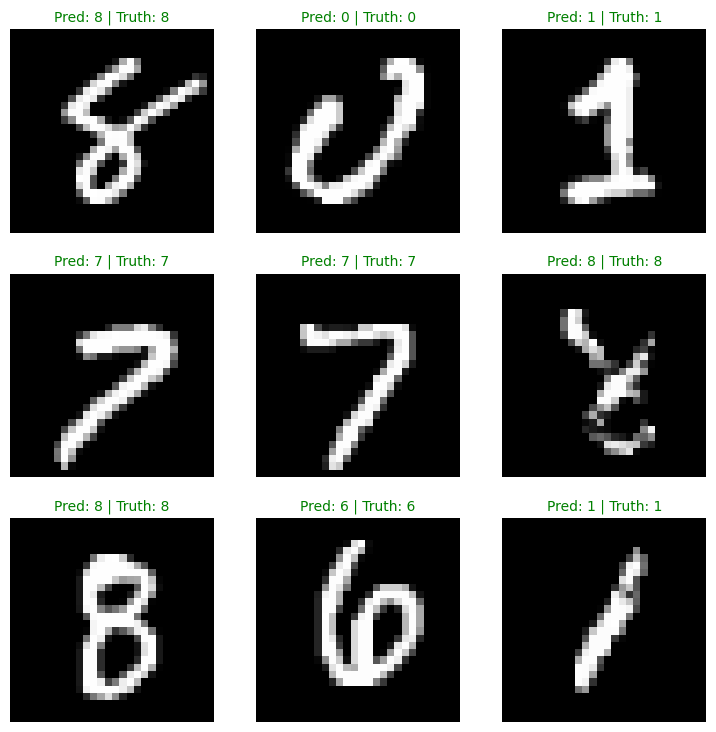

In [22]:
# getting random data
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# making predictions
predictions = []
loaded_model.eval()
with torch.inference_mode():
    for sample in tqdm(test_samples):
        sample = torch.unsqueeze(sample, dim=1).to('cpu')
        y_logit = loaded_model(sample)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=0)
        predictions.append(y_pred.cpu())

y_pred_tensor = torch.stack(predictions)
predictions


# visualizing
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    title = f'Pred: {predictions[i]} | Truth: {test_labels[i]}'
    if predictions[i] == test_labels[i]:
        plt.title(title, fontsize=10, c='g')
    else:
        plt.title(title, fontsize=10, c='r')
    plt.axis(False)

In [23]:
y_preds = []
loaded_model.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc='Making predictions...'):
        X, y = X.to('cpu'), y.to('cpu')
        y_logit = loaded_model(X)
        y_prob = torch.softmax(y_logit, dim=1)  # Convert logits to probabilities
        y_pred = y_prob.argmax(dim=1)  # Get the class label
        y_preds.append(y_pred)

y_preds_tensor = torch.cat(y_preds)

# Display first 10 predictions
print(y_preds_tensor[:10])


Making predictions...: 100%|██████████| 313/313 [00:01<00:00, 192.97it/s]

tensor([8, 9, 2, 7, 1, 6, 1, 5, 9, 1])


In [25]:
from torchmetrics import ConfusionMatrix

all_preds = []
all_targets = []

loaded_model.eval()

with torch.inference_mode():
    for batch in test_dataloader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = loaded_model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds)
        all_targets.append(targets)

all_preds = torch.cat(all_preds, 0)
all_targets = torch.cat(all_targets, 0)

# Initialize the metric
confusion_matrix_metric = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# Compute the confusion matrix
conf_matrix = confusion_matrix_metric(all_preds, all_targets)
print(conf_matrix)


tensor([[ 969,    0,    1,    0,    2,    1,    4,    1,    1,    1],
        [   0, 1130,    0,    1,    0,    0,    2,    0,    2,    0],
        [   2,    1, 1006,    3,    2,    0,    1,   10,    6,    1],
        [   0,    0,    2, 1000,    0,    2,    0,    2,    4,    0],
        [   0,    0,    0,    0,  972,    0,    3,    1,    2,    4],
        [   1,    0,    0,    9,    0,  878,    2,    0,    0,    2],
        [   3,    2,    0,    1,    1,    3,  948,    0,    0,    0],
        [   0,    2,    2,    5,    0,    0,    0, 1017,    0,    2],
        [   2,    0,    1,    7,    2,    1,    1,    1,  948,   11],
        [   0,    4,    1,    4,    4,    4,    0,   10,    1,  981]])


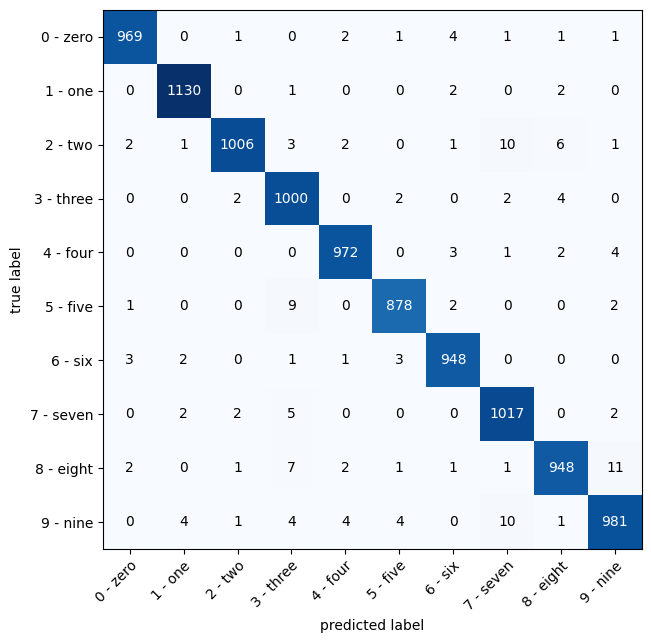

In [26]:
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat = conf_matrix.numpy(),
    class_names=class_names,
    figsize=(10,7)
)